# Real world use case

Below, we use the `mini-gpr` package to fit a model to the [airfoil self-noise](https://archive.ics.uci.edu/dataset/291/airfoil+self+noise) dataset.

In [1]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat"

inputs = [
    "frequency", 
    "angle_of_attack", 
    "chord_length", 
    "free_stream_velocity", 
    "suction_side_displacement_thickness", 
]
output = "scaled_sound_pressure_level"
cols = inputs + [output]

df = pd.read_csv(url, sep=r"\t|\s+", header=None, names=cols, engine="python")
df

frequency  angle_of_attack  chord_length  free_stream_velocity  \
0           800              0.0        0.3048                  71.3   
1          1000              0.0        0.3048                  71.3   
2          1250              0.0        0.3048                  71.3   
3          1600              0.0        0.3048                  71.3   
4          2000              0.0        0.3048                  71.3   
...         ...              ...           ...                   ...   
1498       2500             15.6        0.1016                  39.6   
1499       3150             15.6        0.1016                  39.6   
1500       4000             15.6        0.1016                  39.6   
1501       5000             15.6        0.1016                  39.6   
1502       6300             15.6        0.1016                  39.6   

      suction_side_displacement_thickness  scaled_sound_pressure_level  
0                                0.002663                      126.201  
1                                0.002663                      125.201  
2                                0.002663                      125.951  
3                                0.002663                      127.591  
4                                0.002663                      127.461  
...                                   ...                          ...  
1498                             0.052849                      110.264  
1499                             0.052849                      109.254  
1500                             0.052849                      106.604  
1501                             0.052849                      106.224  
1502                             0.052849                      104.204  

[1503 rows x 6 columns]

In [2]:
# take a random 500 training points, and use the rest for testing
train = df.sample(500)
test = df.drop(train.index)
len(train), len(test)

(500, 1003)

In [3]:
from sklearn.preprocessing import StandardScaler

input_scaler = StandardScaler()
output_scaler = StandardScaler()

X = input_scaler.fit_transform(train[inputs])
y = output_scaler.fit_transform(train[[output]])

In [4]:
from mini_gpr.kernels import RBF
from mini_gpr.models import GPR

model = GPR(RBF(sigma=[0.05] * 5), noise=0.1)
model.fit(X, y)

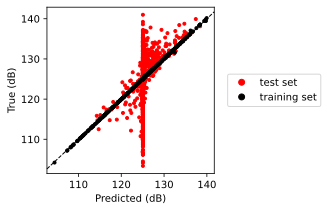

In [5]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

raw_pred_train = model.predict(X)
pred_train = output_scaler.inverse_transform(
    raw_pred_train.reshape(-1, 1)
).flatten()

raw_pred_test = model.predict(input_scaler.transform(test[inputs]))
pred_test = output_scaler.inverse_transform(
    raw_pred_test.reshape(-1, 1)
).flatten()

plt.figure(figsize=(3, 3))
plt.plot(pred_test, test[output], ".r", label="test set")
plt.plot(pred_train, train[output], ".k", label="training set")
plt.axline((pred_train[0], pred_train[0]), slope=1, color="k", ls="--", lw=1)
plt.xlabel("Predicted (dB)")
plt.ylabel("True (dB)")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", markerscale=2);

In [6]:
from mini_gpr.opt import maximise_log_likelihood, optimise_model

best_model = optimise_model(
    model, maximise_log_likelihood, X, y, optimise_noise=True
)
best_model.kernel.params

{'sigma': [0.3196713784422319,
  1.6818896267717998,
  1.3924475424814566,
  0.05,
  0.7961265272752749],
 'scale': 1.246932649911396}

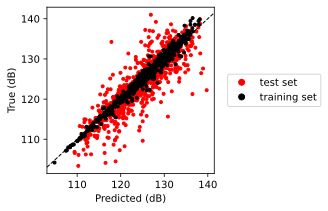

In [7]:
raw_pred_train = best_model.predict(X)
pred_train = output_scaler.inverse_transform(
    raw_pred_train.reshape(-1, 1)
).flatten()

raw_pred_test = best_model.predict(input_scaler.transform(test[inputs]))
pred_test = output_scaler.inverse_transform(
    raw_pred_test.reshape(-1, 1)
).flatten()

plt.figure(figsize=(3, 3))
plt.plot(pred_test, test[output], ".r", label="test set")
plt.plot(pred_train, train[output], ".k", label="training set")
plt.axline((pred_train[0], pred_train[0]), slope=1, color="k", ls="--", lw=1)
plt.xlabel("Predicted (dB)")
plt.ylabel("True (dB)")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", markerscale=2)